# 支持向量回归

Support Vector Regression

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import uniform
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.impute import KNNImputer
from sklearn.model_selection import cross_validate, KFold, \
  GridSearchCV, RandomizedSearchCV
import sklearn.metrics as skmet
import matplotlib.pyplot as plt

import os
import sys
sys.path.append(os.getcwd() + "/helperfunctions")
from preprocfunc import OutlierTrans

pd.set_option('display.width', 200)
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 200)
pd.options.display.float_format = '{:,.2f}'.format

## linear_svr

In [ ]:
from sklearn.svm import LinearSVR

# load data
fftaxrate14 = pd.read_csv("data/fossilfueltaxrate14.csv")
fftaxrate14.set_index('countrycode', inplace=True)

# setup the features and target
num_cols = ['fuel_income_dependence','national_income_per_cap',
  'VAT_Rate',  'gov_debt_per_gdp','polity','goveffect',
  'democracy_index']
dummy_cols = ['democracy_polity','autocracy_polity','democracy',
  'nat_oil_comp','nat_oil_comp_state']
spec_cols = ['motorization_rate']

target = fftaxrate14[['gas_tax_imp']]
features = fftaxrate14[num_cols + dummy_cols + spec_cols]

X_train, X_test, y_train, y_test =  \
  train_test_split(features,\
  target, test_size=0.2, random_state=0)

# generate some summary statistics
X_train.shape

X_train[num_cols + spec_cols].\
  agg(['count','min','median','max']).T

X_train[dummy_cols].count()

X_train[dummy_cols].apply(pd.value_counts, normalize=True).T
 
# setup pipelines for column transformation
standtrans = make_pipeline(OutlierTrans(2), 
 SimpleImputer(strategy="median"), StandardScaler())
cattrans = make_pipeline(SimpleImputer(strategy="most_frequent"))
spectrans = make_pipeline(OutlierTrans(2), StandardScaler())
coltrans = ColumnTransformer(
  transformers=[
    ("stand", standtrans, num_cols),
    ("cat", cattrans, dummy_cols),
    ("spec", spectrans, spec_cols)
  ]
)

# fit an SVR model
svr = LinearSVR(epsilon=0.2, max_iter=10000, random_state=0)

pipe1 = make_pipeline(coltrans, KNNImputer(n_neighbors=5), svr)

ttr=TransformedTargetRegressor(regressor=pipe1,transformer=StandardScaler())

ttr.fit(X_train, y_train)

coefs = ttr.regressor_['linearsvr'].coef_
np.column_stack((coefs.ravel(), num_cols + dummy_cols + spec_cols))


# do kfold cross validation
kf = KFold(n_splits=3, shuffle=True, random_state=0)

ttr.fit(X_train, y_train)

scores = cross_validate(ttr, X=X_train, y=y_train,
  cv=kf, scoring=('r2', 'neg_mean_absolute_error'), n_jobs=1)

print("Mean Absolute Error: %.2f, R-squared: %.2f" %
  (scores['test_neg_mean_absolute_error'].mean(),
  scores['test_r2'].mean()))

# do a grid search to find the best value of alpha
svr = LinearSVR(max_iter=100000, random_state=0)

pipe1 = make_pipeline(coltrans, KNNImputer(n_neighbors=5), svr)

ttr=TransformedTargetRegressor(regressor=pipe1,transformer=StandardScaler())

svr_params = {
  'regressor__linearsvr__epsilon': np.arange(0.1, 1.6, 0.1),
  'regressor__linearsvr__C': np.arange(0.1, 1.6, 0.1)
}

gs = GridSearchCV(ttr,param_grid=svr_params, cv=3, scoring='r2')
%timeit gs.fit(X_train, y_train)

gs.best_params_
gs.best_score_


# do a randomized grid search
svr_params = {
 'regressor__linearsvr__epsilon': uniform(loc=0, scale=1.5),
 'regressor__linearsvr__C': uniform(loc=0, scale=1.5)
}

rs = RandomizedSearchCV(ttr, svr_params, cv=3, scoring='r2', random_state = 123456)
%timeit rs.fit(X_train, y_train)

rs.best_params_
rs.best_score_

# plot the residuals
pred = rs.predict(X_test)

preddf = pd.DataFrame(pred, columns=['prediction'],
  index=X_test.index).join(X_test, how="left", on=None, validate="many_to_many").join(y_test, how="left", on=None, validate="many_to_many")

preddf['resid'] = preddf.gas_tax_imp-preddf.prediction

plt.hist(preddf.resid, color="blue", bins=np.arange(-0.5,1.0,0.25))
plt.axvline(preddf.resid.mean(), color='red', linestyle='dashed', linewidth=1)
plt.title("Histogram of Residuals for Gax Tax Model")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.xlim()
plt.show()

# plot predictions against the residuals
plt.scatter(preddf.prediction, preddf.resid, color="blue")
plt.axhline(0, color='red', linestyle='dashed', linewidth=1)
plt.title("Scatterplot of Predictions and Residuals")
plt.xlabel("Predicted Gax Tax")
plt.ylabel("Residuals")
plt.show()


# do kfold cross validation
X_train, X_test, y_train, y_test =  \
  train_test_split(features,\
  target, test_size=0.1, random_state=22)

kf = KFold(n_splits=3, shuffle=True, random_state=0)

cross_validate(rs, X=X_train, y=y_train,
  cv=kf, scoring=('r2', 'neg_mean_absolute_error'), n_jobs=-1)

## nonlinear_svr

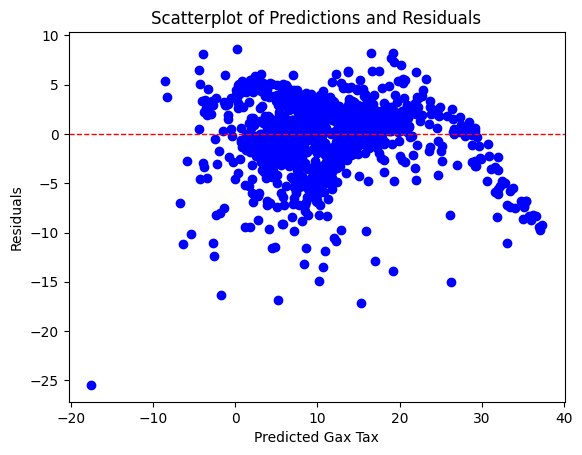

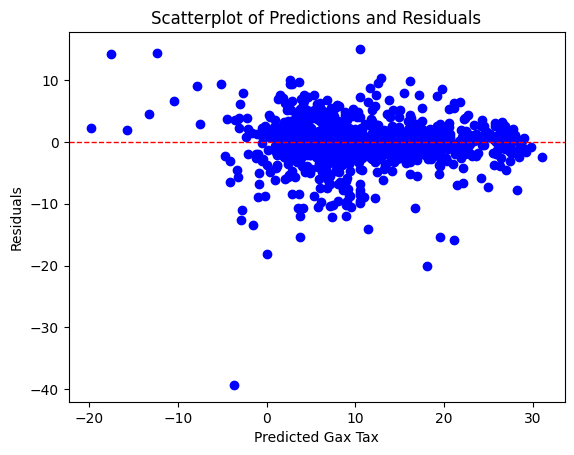

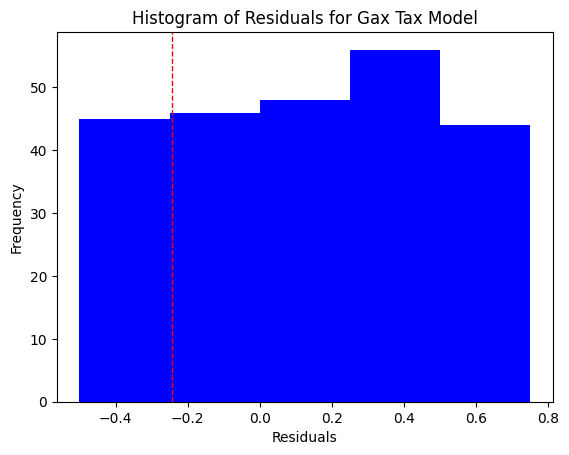

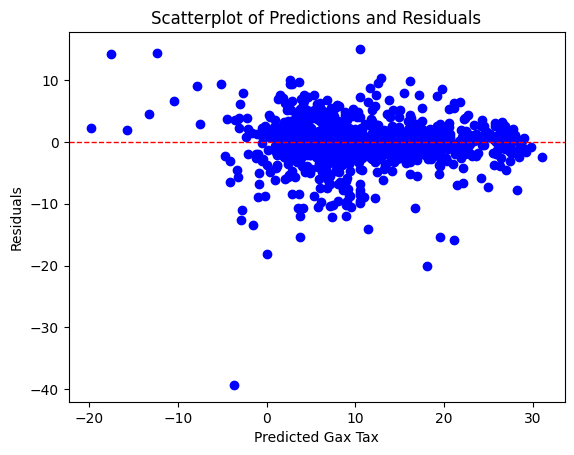

{'fit_time': array([0.01265502, 0.01267076, 0.01244497]),
 'score_time': array([0.01126671, 0.01030612, 0.01023912]),
 'test_r2': array([0.73817221, 0.59817578, 0.34769224]),
 'test_neg_mean_absolute_error': array([-0.17258859, -0.24715787, -0.37228241])}

In [3]:
from sklearn.svm import SVR

# load the land temperatures data
landtemps = pd.read_csv("data/landtempsb2019avgs.csv")
landtemps.set_index('locationid', inplace=True)

feature_cols = ['latabs','elevation']

landtemps[['avgtemp'] + feature_cols].\
  agg(['count','min','median','max']).T

# create training and testing DataFrames
X_train, X_test, y_train, y_test =  \
  train_test_split(landtemps[feature_cols],\
  landtemps[['avgtemp']], test_size=0.1, random_state=0)


# add feature selection and a linear model to the pipeline and look at the parameter estimates
svr = LinearSVR(epsilon=1.0, max_iter=100000, random_state=877874)

knnimp = KNNImputer(n_neighbors=45)

pipe1 = make_pipeline(OutlierTrans(3), knnimp, StandardScaler(), svr)

ttr=TransformedTargetRegressor(regressor=pipe1,
  transformer=StandardScaler())

svr_params = {
 'regressor__linearsvr__epsilon': uniform(loc=0, scale=1.5),
 'regressor__linearsvr__C': uniform(loc=0, scale=20)
}

rs = RandomizedSearchCV(ttr, svr_params, cv=10, scoring='neg_mean_absolute_error', random_state=98763)
rs.fit(X_train, y_train)

rs.best_params_
rs.best_score_


# get predictions and residuals
pred = rs.predict(X_test)

preddf = pd.DataFrame(pred, columns=['prediction'],index=X_test.index)\
  .join(X_test, how="left", on=None, validate="many_to_many")\
    .join(y_test, how="left", on=None, validate="many_to_many")

preddf['resid'] = preddf.avgtemp-preddf.prediction

plt.scatter(preddf.prediction, preddf.resid, color="blue")
plt.axhline(0, color='red', linestyle='dashed', linewidth=1)
plt.title("Scatterplot of Predictions and Residuals")
plt.xlabel("Predicted Gax Tax")
plt.ylabel("Residuals")
plt.show()

# do a grid search to find the best value of alpha
svr = SVR(kernel='rbf')

pipe1 = make_pipeline(OutlierTrans(3), knnimp, StandardScaler(), svr)

ttr=TransformedTargetRegressor(regressor=pipe1,
  transformer=StandardScaler())

svr_params = {
 'regressor__svr__epsilon': uniform(loc=0, scale=5),
 'regressor__svr__C': uniform(loc=0, scale=20),
 'regressor__svr__gamma': uniform(loc=0, scale=100)
 }

rs = RandomizedSearchCV(ttr, svr_params, cv=10, scoring='neg_mean_absolute_error')
rs.fit(X_train, y_train)

rs.best_params_
rs.best_score_

# get predictions and residuals
pred = rs.predict(X_test)

preddf = pd.DataFrame(pred, columns=['prediction'],
  index=X_test.index).join(X_test, how="left", on=None, validate="many_to_many")\
    .join(y_test, how="left", on=None, validate="many_to_many")

preddf['resid'] = preddf.avgtemp-preddf.prediction

plt.scatter(preddf.prediction, preddf.resid, color="blue")
plt.axhline(0, color='red', linestyle='dashed', linewidth=1)
plt.title("Scatterplot of Predictions and Residuals")
plt.xlabel("Predicted Gax Tax")
plt.ylabel("Residuals")
plt.show()


pd.DataFrame(np.logspace(0, 4, 10), columns=['values']).to_excel('views/test.xlsx')

uniform(loc=0, scale=4).rvs(10)
uniform(loc=0.1, scale=2.0).rvs(100)

# plot the residuals
plt.hist(preddf.resid, color="blue", bins=np.arange(-0.5,1.0,0.25))
plt.axvline(preddf.resid.mean(), color='red', linestyle='dashed', linewidth=1)
plt.title("Histogram of Residuals for Gax Tax Model")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.xlim()
plt.show()

# plot predictions against the residuals
plt.scatter(preddf.prediction, preddf.resid, color="blue")
plt.axhline(0, color='red', linestyle='dashed', linewidth=1)
plt.title("Scatterplot of Predictions and Residuals")
plt.xlabel("Predicted Gax Tax")
plt.ylabel("Residuals")
plt.show()


# do kfold cross validation
X_train, X_test, y_train, y_test =  \
  train_test_split(features,\
  target, test_size=0.1, random_state=22)

kf = KFold(n_splits=3, shuffle=True, random_state=0)

cross_validate(ttr, X=X_train, y=y_train,
  cv=kf, scoring=('r2', 'neg_mean_absolute_error'), n_jobs=-1)